In [1]:
import matplotlib as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()
import pymc as pm
import pytensor as pt
import numpy as np

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


**Regular Metropolis crahses because it cannot find a satisfying initial state**

In [2]:
with pm.Model() as model_dirac:
    num_vars = 5

    x = pm.DiscreteUniform('x',0,125,shape=num_vars)
    y = pm.DiscreteUniform('y',0,1,shape=num_vars)

    for i in range(num_vars-1):
        pm.DiracDelta(f'obs{i}', pt.tensor.le(x[i], x[i+1]), observed=True)

    pm.DiracDelta('obs_median_1', pt.tensor.eq(x[2], 30), observed=True)

    pm.DiracDelta(f'obs_sum', pt.tensor.eq(x[0] + x[1] + x[2] + x[3] + x[4], 38*5), observed=True)

    pm.DiracDelta(f'obs_mal', pt.tensor.eq(y[0] + y[1] + y[2] + y[3] + y[4], 3), observed=True)

    pm.DiracDelta(f'obs_mal_sum', pt.tensor.eq(x[0]*y[0] + x[1]*y[1] + x[2]*y[2] + x[3]*y[3] + x[4]*y[4], 44*3), observed=True)

In [3]:
with model_dirac:
    trace = pm.sample(
        draws=10_000,
        tune=1000, # a lot of tunning steps        
    ) 

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'x': array([62, 62, 62, 62, 62]), 'y': array([0, 0, 0, 0, 0])}

Logp initial evaluation results:
{'x': -24.18, 'y': -3.47, 'obs0': 0.0, 'obs1': 0.0, 'obs2': 0.0, 'obs3': 0.0, 'obs_median_1': -inf, 'obs_sum': -inf, 'obs_mal': -inf, 'obs_mal_sum': -inf}
You can call `model.debug()` for more details.

**If we manually provide a satisfying initial state, it cannot find any other satisfying state.**

In [4]:
init_state = {'x': [0, 28, 30, 52, 80], 'y': [1,  0,  0,  1,  1]}
with model_dirac:
    trace = pm.sample(
        draws=10_000,
        tune=1000,
        initvals=init_state
    ) 

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [x]
>Metropolis: [y]


/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 5 seconds.
/home/pardo/programs/miniconda3/envs/sat_metropolis/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


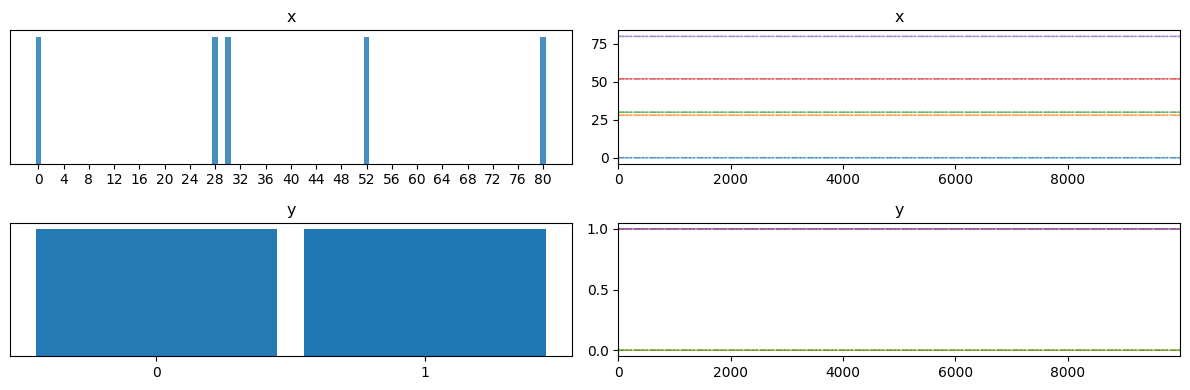

In [5]:
pm.plot_trace(trace);

In [6]:
## Metropolis did not move from the initial state for age variables
np.unique(trace.posterior['x'] == init_state['x'])

array([ True])

In [7]:
## Metropolis did not move from the initial state for sex variables
np.unique(trace.posterior['y'] == init_state['y'])

array([ True])